In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
import seaborn as sns
from  datetime import datetime, timedelta

import os
import gc

In [2]:
path = "C:/Users/Paula/Documents/UvA/AFCS - Applied Forecasting in Complex Systems/Project/AFCS-M5/Data_csv"

sales = pd.read_csv(os.path.join(path, "sales_train_evaluation.csv"))
calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [4]:
sales
print('Sales dataframe dimensions:', sales.shape)

# give some infos on columns types and number of null values
sales_info=pd.DataFrame(sales.dtypes).T.rename(index={0:'column type'})
sales_info=sales_info.append(pd.DataFrame(sales.isnull().sum()).T.rename(index={0:'null values (nb)'}))
sales_info=sales_info.append(pd.DataFrame(sales.max()).T.rename(index={0:'Max value'}))
sales_info.loc['Max value'][0:6] = 0
print('Max sales: '+str(sales_info.loc['Max value'].max()))
sales_info
# sales.info()

Sales dataframe dimensions: (30490, 1947)
Max sales: 763


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
column type,object,object,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Max value,0,0,0,0,0,0,360,436,207,323,296,314,316,370,385,353,279,258,163,107,133,149,122,111,83,...,99,196,132,114,114,143,107,93,179,173,167,119,119,125,89,143,156,187,98,90,77,84,110,156,117


In [5]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [6]:
def downcast(df):
    cols = df.dtypes.index.tolist() 
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [7]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1975 entries, id to d_1969
dtypes: category(6), int16(1317), int8(652)
memory usage: 97.1 MB
None


In [8]:
# Combine columns from the different Dataframes:

df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
display(df.head())
print(df.info())

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(11), datetime64[ns](1), float16(1), int16(3), int8(5

HOBBIES_1_001 sold/price: -0.062005085405233897
HOBBIES_1_010 sold/price: -0.1749232323041529
HOBBIES_2_001 sold/price: -0.07080445437807234
HOBBIES_2_100 sold/price: 0.12824629378020572
HOUSEHOLD_1_001 sold/price: -0.025078362179926022
HOUSEHOLD_1_010 sold/price: -0.10706557602462254
HOUSEHOLD_2_001 sold/price: 0.041250283557046574
HOUSEHOLD_2_100 sold/price: 0.025006340823200423
FOODS_1_001 sold/price: -0.11165616264250212
FOODS_1_010 sold/price: 0.007438605518531248
FOODS_2_001 sold/price: 0.11039703892048788
FOODS_2_100 sold/price: -0.04212269256421


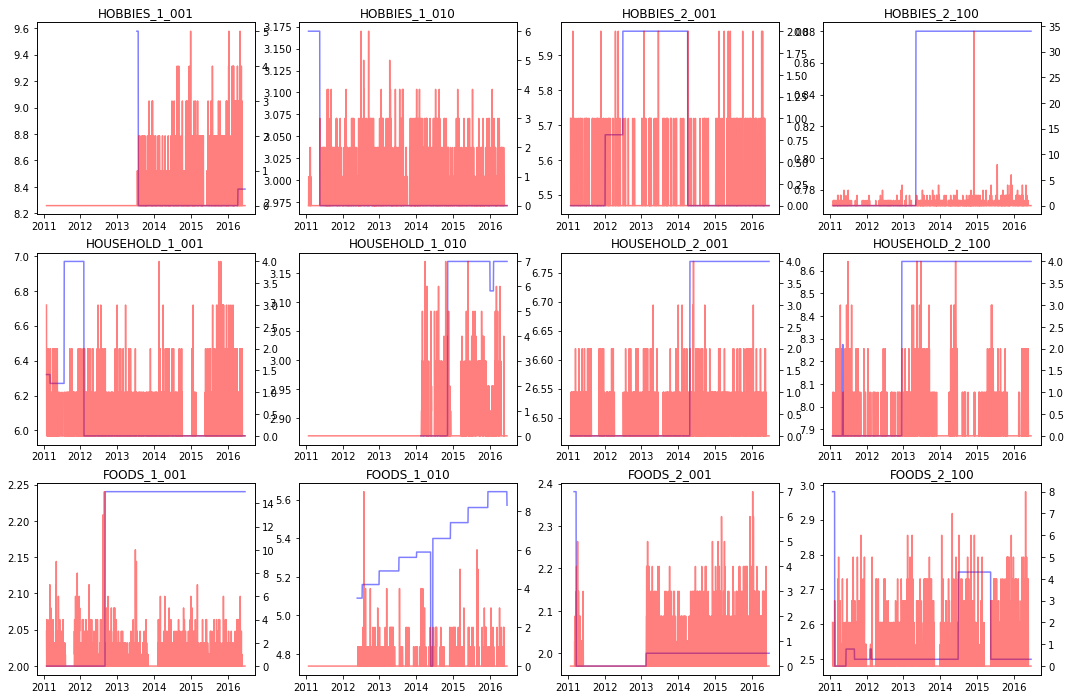

In [14]:
# Easily check the relationship between price and sold for a specific product
# Calculate the correlation coefficient between sold and price

itemID =['HOBBIES_1_001','HOBBIES_1_010','HOBBIES_2_001','HOBBIES_2_100',
        'HOUSEHOLD_1_001','HOUSEHOLD_1_010','HOUSEHOLD_2_001','HOUSEHOLD_2_100',
        'FOODS_1_001','FOODS_1_010','FOODS_2_001','FOODS_2_100']


# For CA_1 store:
r,c=0,0
fig, ax = plt.subplots(3,4,figsize=(18, 12))
df_store = df[df['store_id']=='CA_1']
for i in range(0,12):
    item_df = df_store[df_store['item_id']==itemID[i]]
    print('{} sold/price:'.format(itemID[i]),item_df['sold'].corr(item_df['sell_price']))
    ax2 = ax[r][c].twinx() 
    ax[r][c].plot(item_df['date'],item_df['sell_price'],color='b',alpha=0.5)
    ax2.plot(item_df['date'],item_df['sold'],color='r',alpha=0.5)
    ax[r][c].set_title(itemID[i])
    c+=1
    if c ==4:
        c=0
        r+=1
#plt.savefig('CA_1_price.png')
plt.show()

Price fluctuations are small, with no identifyable patterns.

It is difficult to refer to the correlation coefficient because the fluctuation interval between sold and price is different, but as far as the figure is confirmed, there is no correlation between the price fluctuation of the product and the number of units sold.